# Semi Synthetic Experiment 
Semi-synthetic dataset experiment

In [66]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

# Import Dataset into Notebook

In [2]:
columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
           'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
           'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
          'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


In [68]:
dataset = '/Users/patroklos/Desktop/research/AirQualityUCI.xlsx'
df = pd.read_excel(dataset)
df.head()

# bunch = load_boston()
# data = np.concatenate([bunch['data'], np.expand_dims(bunch['target'], 1)], axis=1)
# df = pd.DataFrame(data, columns=bunch['feature_names'].tolist() + ['MEDV'])
# df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000  0.750239  
3  11.00  60.000000  0.786713  
4  11.15  59.575001  0.788794

In [69]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 1.1+ MB


(None, (9357, 15))

The first thing that we want to do is check if there are any columns with NaN values in the dataframe.

In [70]:
# normally, using isna().sum() would be enough to find missing vals but for this dataset, missing values have been tagged as -200. 
# we'll have to go through each column to find -200 values and then pass judgement as to dropping rows or entire columns. 

columns = {"Date", "Time", "CO(GT)", "PT08.S1(CO)", "NMHC(GT)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH"}

def findNumOfMissingVals(col):
    allValues = []
    
    for column in col:
        val = 0 
        for i in df[column]:
            if i == -200:
                val += 1
        allValues.append(val)
                         
    return allValues

values = findNumOfMissingVals(["Date", "Time", "CO(GT)", "PT08.S1(CO)", "NMHC(GT)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH"])
valuesMapped = dict(zip(sorted(columns), values))

valuesMapped

{'AH': 0,
 'C6H6(GT)': 0,
 'CO(GT)': 1683,
 'Date': 366,
 'NMHC(GT)': 8443,
 'NO2(GT)': 366,
 'NOx(GT)': 366,
 'PT08.S1(CO)': 1639,
 'PT08.S2(NMHC)': 366,
 'PT08.S3(NOx)': 1642,
 'PT08.S4(NO2)': 366,
 'PT08.S5(O3)': 366,
 'RH': 366,
 'T': 366,
 'Time': 366}

In [71]:
df.drop('NMHC(GT)', axis=1, inplace=True)

In [72]:
# Replace -200 with null values.
def replaceValues(value1, value2, df):
    df = df.replace(value1, value2)
    return df

df2 = df.copy()

df2 = replaceValues(-200, np.nan, df2)

# go through rows and drop rows w/ 1 or more NaN values. 
def dropMissingRows(df):
    df = df.dropna(axis=0)
    return df
    
df2 = dropMissingRows(df2)

df2 = df2.sort_values(by=['Date'], ascending=True)

# checking new data 
df2.head()

Date      Time  CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  \
0 2004-03-10  18:00:00     2.6      1360.00  11.881723        1045.50   
1 2004-03-10  19:00:00     2.0      1292.25   9.397165         954.75   
2 2004-03-10  20:00:00     2.2      1402.00   8.997817         939.25   
3 2004-03-10  21:00:00     2.2      1375.50   9.228796         948.25   
4 2004-03-10  22:00:00     1.6      1272.25   6.518224         835.50   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)      T  \
0    166.0       1056.25    113.0       1692.00      1267.50  13.60   
1    103.0       1173.75     92.0       1558.75       972.25  13.30   
2    131.0       1140.00    114.0       1554.50      1074.00  11.90   
3    172.0       1092.00    122.0       1583.75      1203.25  11.00   
4    131.0       1205.00    116.0       1490.00      1110.00  11.15   

          RH        AH  
0  48.875001  0.757754  
1  47.700000  0.725487  
2  53.975000  0.750239  
3  60.000000  0.786713  
4  59.575001  0.788794

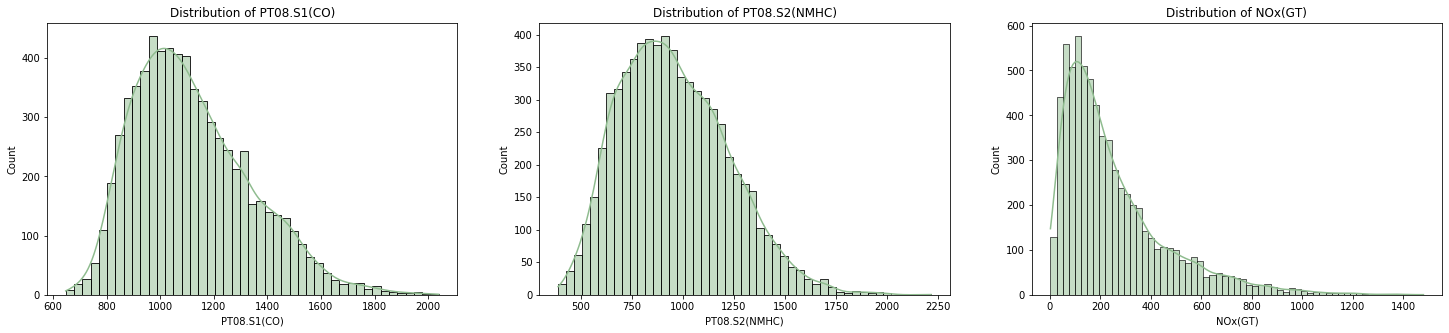

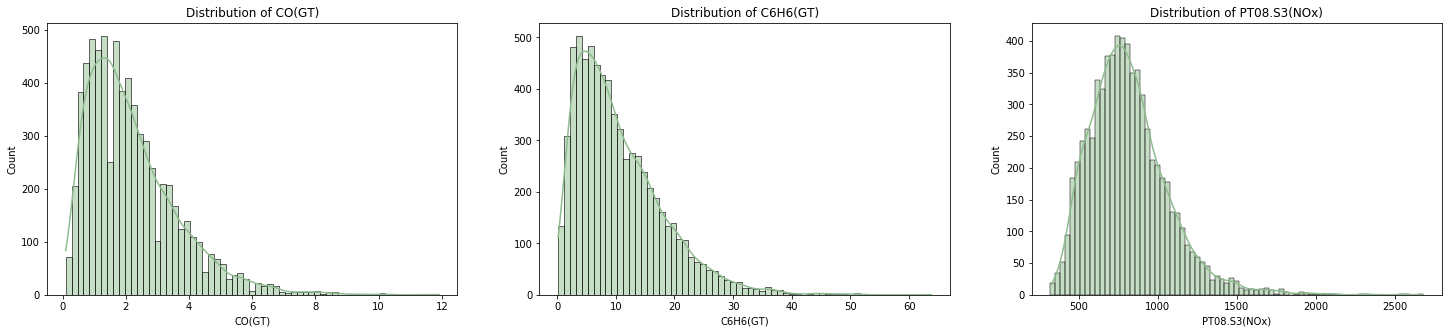

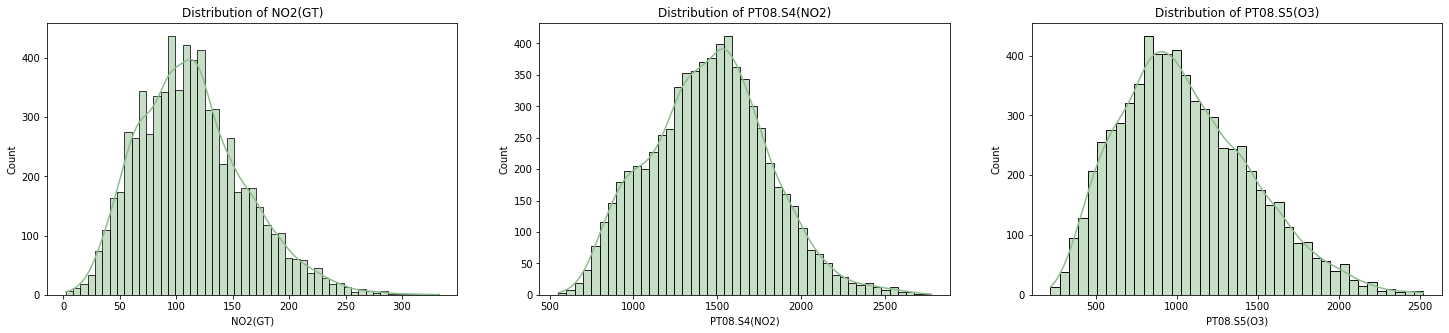

In [8]:
# more data exploration through visualizing

def showDistributions(category1, category2, category3):
    fig, axes = plt.subplots(1,3, figsize=(25, 5))
    sns.histplot(data=df2, x=category1, kde=True, color="darkseagreen", ax=axes[0])
    axes[0].set_title("Distribution of {}".format(category1))
    sns.histplot(data=df2, x=category2, kde=True, color="darkseagreen", ax=axes[1])
    axes[1].set_title("Distribution of {}".format(category2))
    sns.histplot(data=df2, x=category3, kde=True, color="darkseagreen", ax=axes[2])
    axes[2].set_title("Distribution of {}".format(category3))

showDistributions("PT08.S1(CO)", "PT08.S2(NMHC)", "NOx(GT)")
showDistributions("CO(GT)", "C6H6(GT)", "PT08.S3(NOx)")
showDistributions("NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)")

# Data Exploration

# Create Correlation Matrix
Create a correlation matrix to see which features are correlated to air quality data collection.

In [9]:
corr_matrix = df2.corr()
corr_matrix

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
CO(GT)         1.000000     0.877019  0.930026       0.914316  0.786483   
PT08.S1(CO)    0.877019     1.000000  0.877458       0.886075  0.707738   
C6H6(GT)       0.930026     0.877458  1.000000       0.982711  0.718410   
PT08.S2(NMHC)  0.914316     0.886075  0.982711       1.000000  0.705407   
NOx(GT)        0.786483     0.707738  0.718410       0.705407  1.000000   
PT08.S3(NOx)  -0.701025    -0.762875 -0.725674      -0.781613 -0.662149   
NO2(GT)        0.674026     0.628432  0.603519       0.633592  0.757079   
PT08.S4(NO2)   0.630828     0.675896  0.761788       0.774261  0.233839   
PT08.S5(O3)    0.853481     0.897166  0.861186       0.876784  0.788560   
T              0.018336     0.028281  0.188942       0.228300 -0.276028   
RH             0.064758     0.169237 -0.021527      -0.046065  0.232244   
AH             0.059345     0.149743  0.187023       0.205563 -0.144141   

               PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T  \
CO(GT)            -0.701025  0.674026      0.630828     0.853481  0.018336   
PT08.S1(CO)       -0.762875  0.628432      0.675896     0.897166  0.028281   
C6H6(GT)          -0.725674  0.603519      0.761788     0.861186  0.188942   
PT08.S2(NMHC)     -0.781613  0.633592      0.774261     0.876784  0.228300   
NOx(GT)           -0.662149  0.757079      0.233839     0.788560 -0.276028   
PT08.S3(NOx)       1.000000 -0.641436     -0.511208    -0.793350 -0.099496   
NO2(GT)           -0.641436  1.000000      0.142930     0.702659 -0.214170   
PT08.S4(NO2)      -0.511208  0.142930      1.000000     0.574230  0.566676   
PT08.S5(O3)       -0.793350  0.702659      0.574230     1.000000 -0.046160   
T                 -0.099496 -0.214170      0.566676    -0.046160  1.000000   
RH                -0.116470 -0.075405     -0.009155     0.164813 -0.563823   
AH                -0.223384 -0.349421      0.646395     0.075794  0.660741   

                     RH        AH  
CO(GT)         0.064758  0.059345  
PT08.S1(CO)    0.169237  0.149743  
C6H6(GT)      -0.021527  0.187023  
PT08.S2(NMHC) -0.046065  0.205563  
NOx(GT)        0.232244 -0.144141  
PT08.S3(NOx)  -0.116470 -0.223384  
NO2(GT)       -0.075405 -0.349421  
PT08.S4(NO2)  -0.009155  0.646395  
PT08.S5(O3)    0.164813  0.075794  
T             -0.563823  0.660741  
RH             1.000000  0.179575  
AH             0.179575  1.000000

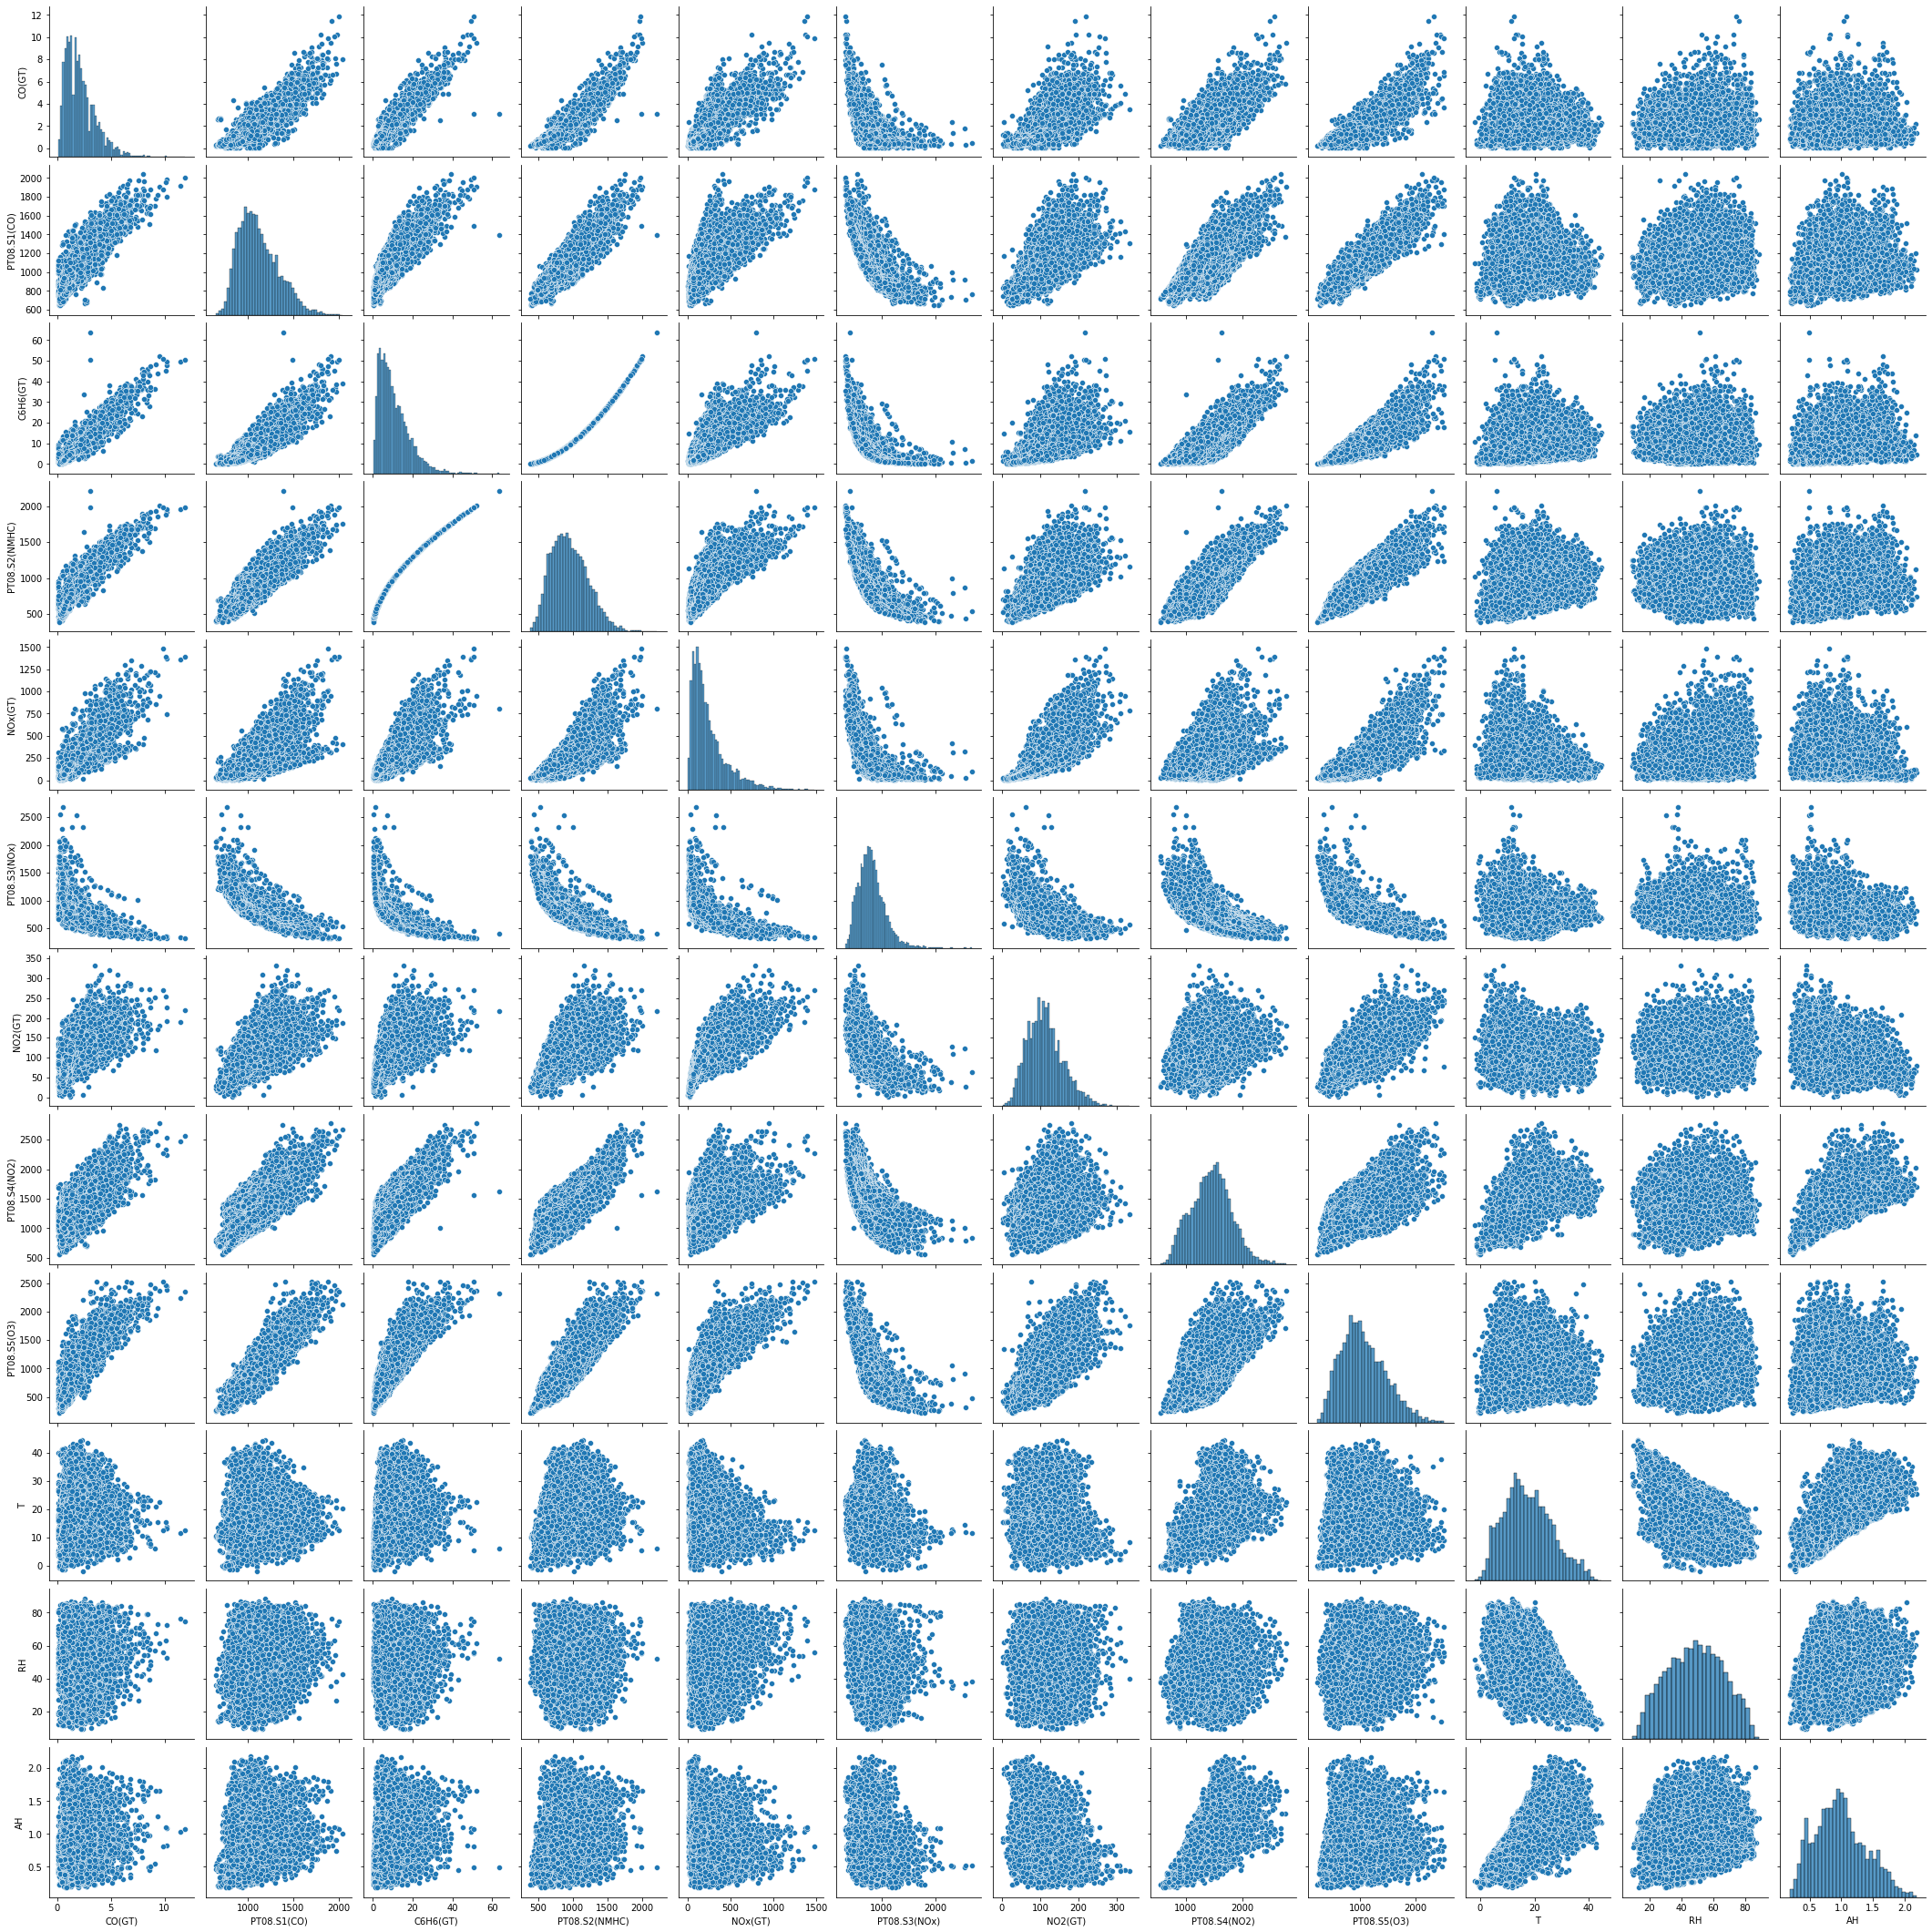

In [10]:
sns.pairplot(df2)

In [38]:
x_cols = ['PT08.S4(NO2)', 'PT08.S2(NMHC)']
X, y = df2[x_cols].to_numpy(), df2['NO2(GT)'].to_numpy().reshape(-1, 1)

X, y = Tensor(X), Tensor(y)

In [39]:
data = ch.linspace(0, 1500, 100).reshape(100, 1)

gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("r^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

r^2:  0.7031718118814598
ground-truth variance:  668.7236938476562


# Now we standardize our empirical data and generate new ols estimates

In [40]:
# random = ch.randn(X.shape[1], 2)
random = ch.eye(X.shape[1])
x_transform = X@random
w_transform = Tensor(gt_ols.coef_)@random

ValueError: x and y must be the same size

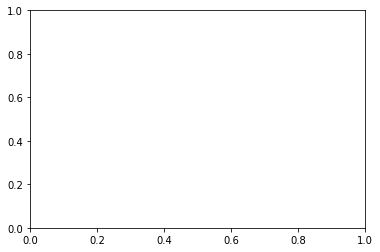

In [41]:
data = ch.linspace(100, 3000, 100)[...,None]
plt.scatter(X, y, label='data')
plt.plot(data, gt_ols.predict(data), color='r', label='gt')
plt.xlabel('PT08.S4(NO2)')
plt.ylabel('NO2(GT)')
plt.legend()

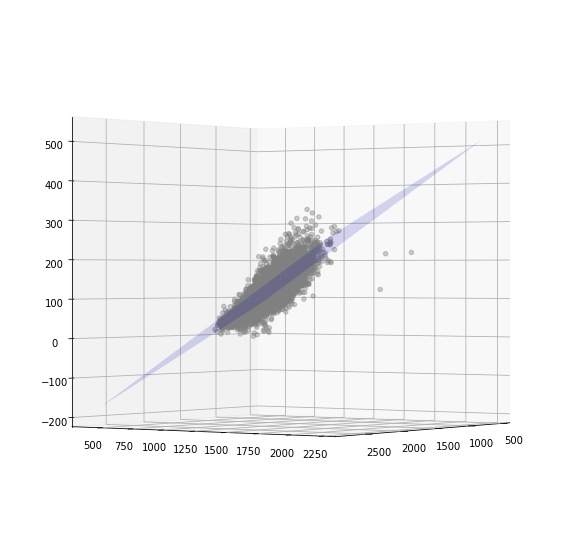

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5.0)
Y = np.arange(x_min[1], x_max[1], 5.0)
X_, Y = np.meshgrid(X_, Y) 


actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 35)

# Truncate Dataset

In [49]:
phi = oracle.Right(100)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

alpha:  0.4123325169283965


In [50]:
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))

r^2:  0.2140539420328771
empirical variance:  223.88397216796875


In [51]:
x_trunc_transform = x_transform[indices]
w = Tensor(trunc_ols.coef_)@random

# Truncate Regression


# Data Preprocessing
We will now use our algorithms to try to correct for this bias.

In [52]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

scaled_ols = LinearRegression()
scaled_ols.fit(x_norm, y_scaled)

trunc_scaled_ols = LinearRegression()
trunc_scaled_ols.fit(x_trunc_norm, y_trunc_scaled)

LinearRegression()

In [53]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(x_norm, y_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(x_trunc_norm, y_trunc_emp_scaled)

LinearRegression()

ValueError: x and y must be the same size

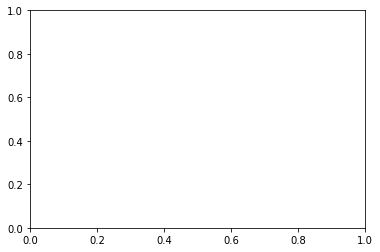

In [33]:
data = ch.linspace(.2, 1, 100)[...,None]
plt.scatter(x_trunc_norm, y_trunc_scaled, label='S', color='grey', alpha=.5)
plt.plot(data, scaled_ols.predict(data), color='b', label='gt')
plt.plot(data, trunc_scaled_ols.predict(data), color='r', label='trunc ols')
plt.xlabel('PTO8.S2(NMHC)')
plt.ylabel('CO(GT)')
plt.legend()

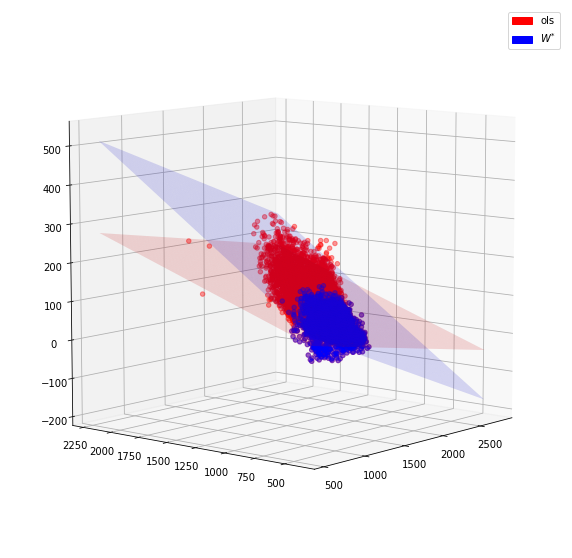

In [54]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5)
Y = np.arange(x_min[1], x_max[1], 5)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='blue', label='S', alpha=.4)

red_patch = mpatches.Patch(color='red', label='ols')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch], loc="upper right")
    
ax.view_init(9.0, 220)

Now, we will our truncated regression algorithm with known variance of the truncated regression data.

In [55]:
scaled_phi = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(gt_var))
known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=1e-1, unknown=False, bs=10, n=100, tol=1e-2, steps=2500, val=int(.1*y_trunc.size(0)))
known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)

Iteration 1 | Score: 0.06713267415761948
Iteration 2 | Score: 0.030102476477622986
Final Score: 0.005460431799292564


Linear(in_features=2, out_features=1, bias=True)

In [56]:
known_w, known_w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

In [57]:
mse_loss(ch.cat([known_w.flatten(), known_w0]), ch.cat([Tensor(gt_ols.coef_.flatten()), Tensor(gt_ols.intercept_)]))**.5

tensor(3.3319)

In [58]:
mse_loss(ch.cat([Tensor(trunc_ols.coef_.flatten()), Tensor(trunc_ols.intercept_)]), ch.cat([Tensor(gt_ols.coef_.flatten()), Tensor(gt_ols.intercept_)]))**.5






tensor(7.0737)

In [59]:
(y_trunc_scaled - trunc_scaled_ols.predict(x_trunc_norm)).var(0)

tensor([0.3348])

ValueError: x and y must be the same size

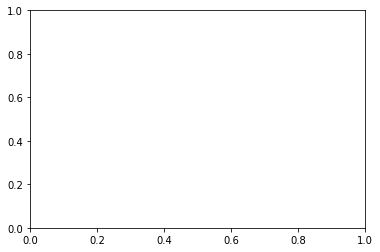

In [24]:
data = ch.linspace(.2, 1, 100)[...,None]
plt.scatter(x_trunc_norm, y_trunc_scaled, label='S', color='grey', alpha=.5)
plt.plot(data, scaled_ols.predict(data), color='b', label='gt')
with ch.no_grad():
    plt.plot(data, known_trunc_reg(data), color='g', label='our algorithm')
plt.plot(data, trunc_scaled_ols.predict(data), color='r')
plt.xlabel('PTO8.S2(NMHC)')
plt.ylabel('CO(GT)')
plt.legend()

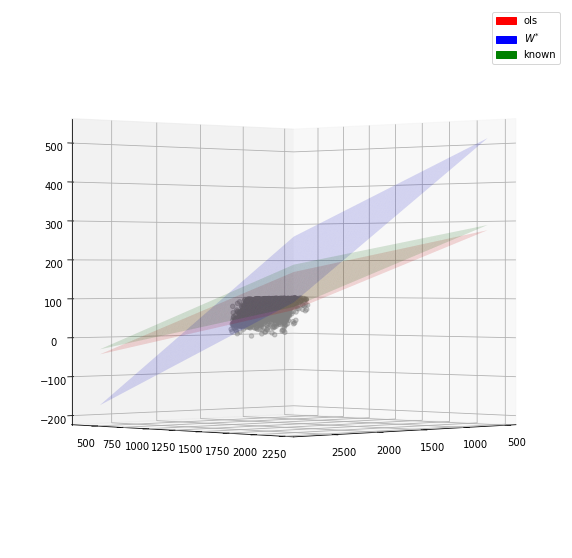

In [62]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5)
Y = np.arange(x_min[1], x_max[1], 5)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    known_w_transform = known_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0][...,None], x_trunc_transform[:,1][...,None], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='known')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 45)

In [30]:
emp_scaled_phi = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(emp_var))
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=1e-1, step_lr_gamma=.9, bs=10, n=1, tol=1e-1, steps=5000, val=int(.2*y_trunc.size(0)))
unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)

NameError: name 'emp_var' is not defined

ValueError: x and y must be the same size

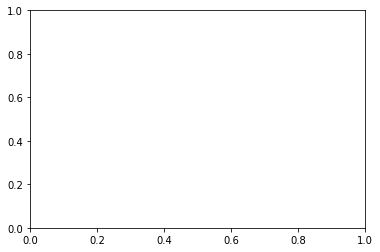

In [529]:
data = ch.linspace(0.0, 1, 100)[...,None]
plt.scatter(x_trunc_norm, y_trunc_emp_scaled, label='S', color='grey', alpha=.5)
plt.plot(data, emp_scaled_ols.predict(data), color='b', label='gt')
with ch.no_grad():
    plt.plot(data, unknown_trunc_reg(data), color='g', label='our algorithm')
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='r', label='ols')
plt.xlabel('PTO8.S2(NMHC)')
plt.ylabel('CO(GT)')
plt.legend()

In [28]:
unknown_w, unknown_w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

NameError: name 'unknown_trunc_reg' is not defined

NameError: name 'x_transform' is not defined

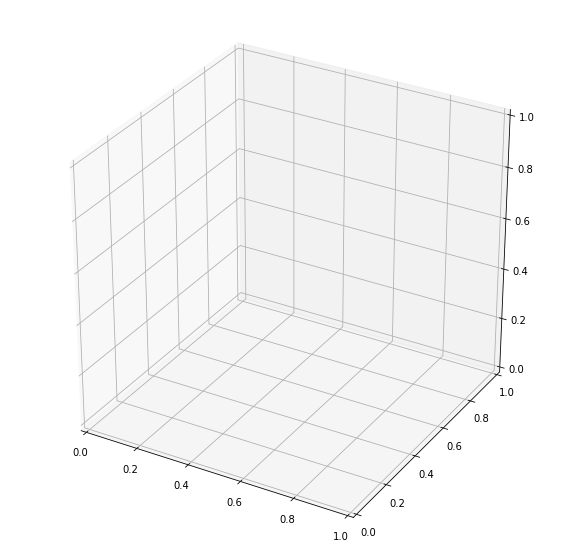

In [29]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5)
Y = np.arange(x_min[1], x_max[1], 5)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = unknown_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + unknown_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0][...,None], x_trunc_transform[:,1][...,None], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='known')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 180)

In [ ]:
unknown_trunc_reg.score()

In [30]:
gt_params

NameError: name 'gt_params' is not defined

In [53]:
w_, w0_ = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu





NameError: name 'unknown_trunc_reg' is not defined

In [54]:
ch.sqrt(mse_loss(ch.cat([unknown_w.flatten(), unknown_w0.flatten()]), gt_params))

NameError: name 'unknown_w' is not defined

In [55]:
emp_scaled_ols_params = Tensor(np.concatenate([emp_scaled_ols.coef_.flatten(), emp_scaled_ols.intercept_]))
trunc_emp_scaled_ols_params = Tensor(np.concatenate([trunc_emp_scaled_ols.coef_.flatten(), trunc_emp_scaled_ols.intercept_]))
emp_scaled_unknown_params = Tensor(np.concatenate([unknown_trunc_reg.weight.flatten(), unknown_trunc_reg.intercept.flatten()]))

NameError: name 'unknown_trunc_reg' is not defined

In [34]:
mse_loss(trunc_emp_scaled_ols_params, emp_scaled_ols_params)

tensor(0.0101)

In [35]:
unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

tensor([[-22.3848]])

In [36]:
Tensor(trunc_emp_scaled_ols.intercept_) * ch.sqrt(emp_var) + y_trunc_mu, Tensor(emp_scaled_ols.intercept_) *(ch.sqrt(emp_var)) + y_trunc_mu

(tensor([-22.3848]), tensor([-22.8026]))

In [37]:
mse_loss(emp_scaled_unknown_params, emp_scaled_ols_params)

tensor(0.0101)

In [38]:
ch.cat([unknown_w.flatten(), unknown_w0.flatten()])

tensor([ -0.0691,   0.2112, -22.3848])

In [39]:
ch.sqrt(mse_loss(Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_])), gt_params))

NameError: name 'gt_params' is not defined

In [40]:
gt_params

NameError: name 'gt_params' is not defined

In [41]:
Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))

tensor([ -0.0691,   0.2112, -22.3853])

In [42]:
unknown_pred = X@unknown_w + unknown_w0

In [43]:
r2_score(y, unknown_pred)

0.5411272624409258

In [44]:
r2_score(y, trunc_ols.predict(X))

0.5411272100269564

In [66]:
r2_score(y, gt_ols.predict(X))

0.5411531520066606

In [100]:
unknown_trunc_reg.variance * emp_var

tensor([[803.4533]])

In [102]:
gt_var

tensor([1033.5864])

In [104]:
unkn

tensor([1016.5268])

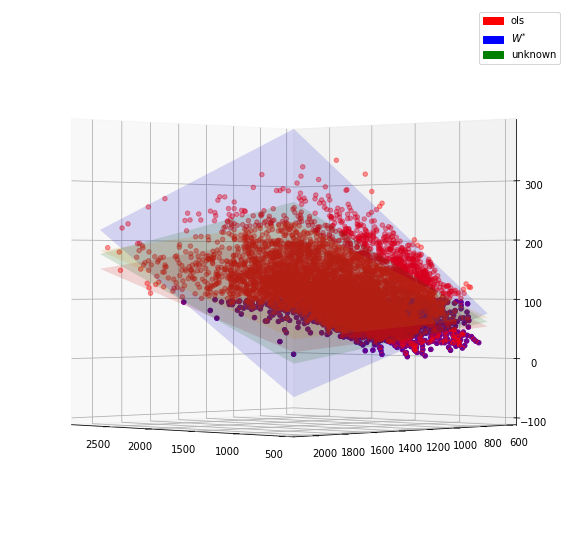

In [67]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 1.0)
Y = np.arange(x_min[1], x_max[1], 1.0)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = w_.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + w0_], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')
    
    known_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        known_pred = ch.cat([known_pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='blue', label='S', alpha=1.0)
    
red_patch = mpatches.Patch(color='red', label='ols')
orange_patch = mpatches.Patch(color='red', label='known')
green_patch = mpatches.Patch(color='green', label='unknown')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 135)

In [16]:
unknown_params = ch.cat([w_, w0_]).flatten()
gt_params = Tensor(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
trunc_ols_params = Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))
known_params = ch.cat([known_w.flatten(), known_w0.flatten()])

NameError: name 'w_' is not defined

In [88]:
gt_params

tensor([ -0.0697,   0.2125, -22.8026])

In [400]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

In [401]:
mse_loss(trunc_reg_params, gt_params)

tensor(6.1154)

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [13]:
args = Parameters({
    "bs": 10,
    "trials": 10,
    "steps": 1500,
    "out_dir": '/Users/patroklos/regression', 
    "table_name": 'results', 
    'tol': 5e-2,
    'n': 100,
    'lr': 1e-1,
    'step_lr': 100, 
    'step_lr_gamma': .9,
    'attempts': 3, 
    'val': .2,
})
EXP = 'DiffFeaturesAgain'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [14]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time   

# Run Procedure

In [15]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))
gt_r2 = r2_score(y, gt.predict(X))

C = [300, 250, 225, 200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
#         'known_unknown_r2': float,
#         'known_unknown_param_mse': float,
#         'known_unknown_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_l1': float,
        'trunc_reg_r2': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Right(c)
        indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[indices], y[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / X.size(0)])
        
        y_trunc_mu = y_trunc.mean(0)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        print("c: ", c)
        print("emp noise var: ", emp_noise_var)
        print("gt var: ", gt_var)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        val = int(args.val*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
        phi_scaled = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
            
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled, args.tol, args.attempts) 
        
        w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu 
        known_params = ch.cat([w.flatten(), w0])
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(y.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })
        
        phi_emp_scaled = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled, args.tol, args.attempts)  
        
        w, w0 = (trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w.flatten(), w0.flatten()])
        # known results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(y.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_time': total_time, 
            'unknown_var_l1': ch.abs(trunc_reg.variance * emp_noise_var - gt_var)
        })
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(x_trunc.size(1)), 'right', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_l1': ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
        })   

#         unknown_pred_var = trunc_reg.variance * emp_noise_var
        
#         phi_known_unknown_scaled = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(unknown_pred_var))
        
#         # standardize noised by actual noise variance
#         known_kwargs = { 
#             'phi': phi_known_unknown_scaled, 
#             'alpha': alpha, 
#             'bias': args.bias, 
#             'unknown': False, 
#             'bs': args.bs, 
#             'n': args.n, 
#             'tol': args.tol, 
#             'steps': args.steps, 
#             'step_lr': args.step_lr, 
#             'step_lr_gamma': args.step_lr_gamma,
#             'val': val
            
#         }
        
#         # truncated linear regression with known noise variance using empirical noise variance
#         unknown_known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled, args.tol, args.attempts) 
        
#         w, w0 = (unknown_known_trunc_reg.weight * ch.sqrt(unknown_pred_var)) / beta, unknown_known_trunc_reg.intercept * ch.sqrt(unknown_pred_var) + y_trunc_mu 
#         known_unknown_params = ch.cat([w.flatten(), w0.flatten()])
#         # known results
#         store[TABLE_NAME].update_row({
#             'known_unknown_r2': r2_score(y.flatten(), X@w + w0), 
#             'known_unknown_param_mse': mse_loss(known_unknown_params, gt_params),
#             'known_unknown_time': total_time, 
#         })
        
        
        
        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /Users/patroklos/regression/DiffFeaturesAgain/ea61e5d4-1ab0-44b2-9bfb-62e026b5cb14
c:  300
emp noise var:  tensor([[656.4963]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.3161742389202118
Iteration 2 | Score: 0.1309402883052826
Iteration 3 | Score: 0.21341381967067719
Final Score: 0.03633727878332138
c:  250
emp noise var:  tensor([[614.7814]])
gt var:  tensor([668.6274])
c:  225
emp noise var:  tensor([[579.3836]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.16070100665092468
Iteration 2 | Score: 0.08719653636217117
Iteration 3 | Score: 0.16083912551403046
Iteration 4 | Score: 0.1748318076133728
Iteration 5 | Score: 0.13154985010623932
Iteration 6 | Score: 0.15239231288433075
Iteration 7 | Score: 0.15557648241519928
Final Score: 0.03662988170981407
c:  200
emp noise var:  tensor([[510.1622]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.23787666857242584
Iteration 2 | Score: 0.2872086465358734
Iteration 3 | Score: 0.06944650411605835
Iteration 4 | Scor

Iteration 2 | Score: 0.08668754994869232
Final Score: 0.01789773255586624
c:  160
emp noise var:  tensor([[403.6641]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.09614621847867966
Iteration 2 | Score: 0.07823851704597473
Final Score: 0.008456692099571228
Iteration 1 | Score: 0.09114032238721848
Iteration 2 | Score: 0.1452530473470688
Final Score: 0.011227341368794441
c:  150
emp noise var:  tensor([[369.4693]])
gt var:  tensor([668.6274])
Final Score: 0.04009322077035904
Iteration 1 | Score: 0.11123652756214142
Iteration 2 | Score: 0.1497163474559784
Iteration 3 | Score: 0.11174620687961578
Iteration 4 | Score: 0.06074058637022972
Iteration 5 | Score: 0.17754675447940826
Iteration 6 | Score: 0.0573853962123394
Iteration 7 | Score: 0.06887015700340271
Final Score: 0.047734376043081284
Iteration 1 | Score: 0.11469286680221558
Iteration 2 | Score: 0.1060502752661705
Iteration 3 | Score: 0.14916618168354034
Iteration 4 | Score: 0.1837162971496582
Iteration 5 | Score: 0.162965208292

Iteration 3 | Score: 0.41489553451538086
Iteration 4 | Score: 0.27812033891677856
Iteration 5 | Score: 0.11928290128707886
Iteration 6 | Score: 0.13161157071590424
Iteration 7 | Score: 0.13131390511989594
Iteration 8 | Score: 0.15664803981781006
Iteration 9 | Score: 0.12140841037034988
Iteration 10 | Score: 0.1323373019695282
Final Score: 0.023167084902524948
c:  200
emp noise var:  tensor([[510.1622]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.3878244161605835
Iteration 2 | Score: 0.0726044774055481
Iteration 3 | Score: 0.2651202380657196
Iteration 4 | Score: 0.17770297825336456
Final Score: 0.04989383742213249
Iteration 1 | Score: 0.22671328485012054
Iteration 2 | Score: 0.06129498779773712
Iteration 3 | Score: 0.231162890791893
Iteration 4 | Score: 0.17380893230438232
Iteration 5 | Score: 0.18326352536678314
Iteration 6 | Score: 0.25534167885780334
Iteration 7 | Score: 0.08336390554904938
Iteration 8 | Score: 0.19554245471954346
Iteration 9 | Score: 0.2563476860523224
Itera

Final Score: 0.02498978190124035
c:  110
emp noise var:  tensor([[254.0055]])
gt var:  tensor([668.6274])
Final Score: 0.005270276218652725
Iteration 1 | Score: 0.1864386796951294
Final Score: 0.044511374086141586
c:  100
emp noise var:  tensor([[223.8840]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.07045596837997437
Iteration 2 | Score: 0.05509292706847191
Iteration 3 | Score: 0.09289424866437912
Iteration 4 | Score: 0.06314241886138916
Final Score: 0.024983925744891167
Iteration 1 | Score: 0.12238980829715729
Iteration 2 | Score: 0.20030425488948822
Iteration 3 | Score: 0.2099810540676117
Iteration 4 | Score: 0.09710913151502609
Iteration 5 | Score: 0.1533973664045334
Iteration 6 | Score: 0.18288397789001465
Final Score: 0.022819876670837402
Logging in: /Users/patroklos/regression/DiffFeaturesAgain/b5419217-a184-4622-89d8-8b81f71b37b7
c:  300
emp noise var:  tensor([[656.4963]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.051662884652614594
Iteration 2 | Score: 0.1358

Iteration 3 | Score: 0.10437195003032684
Iteration 4 | Score: 0.16891977190971375
Iteration 5 | Score: 0.14943169057369232
Final Score: 0.035748131573200226
c:  170
emp noise var:  tensor([[435.1725]])
gt var:  tensor([668.6274])
Final Score: 0.003111580153927207
Iteration 1 | Score: 0.3989936411380768
Final Score: 0.048035960644483566
Iteration 1 | Score: 0.1198585256934166
Iteration 2 | Score: 0.12370684742927551
Final Score: 0.038006603717803955
c:  160
emp noise var:  tensor([[403.6641]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.07308780401945114
Iteration 2 | Score: 0.06323594599962234
Iteration 3 | Score: 0.11587861180305481
Final Score: 0.02147955447435379
Iteration 1 | Score: 0.14575453102588654
Iteration 2 | Score: 0.14703010022640228
Iteration 3 | Score: 0.155456081032753
Iteration 4 | Score: 0.12219888716936111
Iteration 5 | Score: 0.11384842544794083
Iteration 6 | Score: 0.13296420872211456
Iteration 7 | Score: 0.09852307289838791
Iteration 8 | Score: 0.1366064250

Iteration 5 | Score: 0.13631361722946167
Iteration 6 | Score: 0.11559167504310608
Iteration 7 | Score: 0.07549622654914856
Iteration 8 | Score: 0.1575974076986313
Iteration 9 | Score: 0.09042658656835556
Iteration 10 | Score: 0.10970041155815125
Iteration 11 | Score: 0.19992394745349884
Iteration 12 | Score: 0.18872423470020294
Iteration 13 | Score: 0.16682420670986176
Final Score: 0.045749351382255554
c:  150
emp noise var:  tensor([[369.4693]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.07901474833488464
Iteration 2 | Score: 0.10904441773891449
Final Score: 0.00020558247342705727
Iteration 1 | Score: 0.053865041583776474
Iteration 2 | Score: 0.3045373558998108
Final Score: 0.02729891799390316
c:  140
emp noise var:  tensor([[342.5495]])
gt var:  tensor([668.6274])
Final Score: 0.019336482509970665
Iteration 1 | Score: 0.2706678509712219
Iteration 2 | Score: 0.07568170130252838
Iteration 3 | Score: 0.09403549134731293
Final Score: 0.036979854106903076
c:  130
emp noise var:  t

Final Score: 0.03136091306805611
c:  200
emp noise var:  tensor([[510.1622]])
gt var:  tensor([668.6274])
Final Score: 0.022013932466506958
c:  190
emp noise var:  tensor([[483.6461]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.11082624644041061
Final Score: 0.041739434003829956
c:  180
emp noise var:  tensor([[459.4071]])
gt var:  tensor([668.6274])
Final Score: 0.03718021139502525
Iteration 1 | Score: 0.16959218680858612
Iteration 2 | Score: 0.14355047047138214
Iteration 3 | Score: 0.05758308246731758
Iteration 4 | Score: 0.30257976055145264
Iteration 5 | Score: 0.10931720584630966
Iteration 6 | Score: 0.18768469989299774
Iteration 7 | Score: 0.251043438911438
Final Score: 0.03556373715400696
c:  170
emp noise var:  tensor([[435.1725]])
gt var:  tensor([668.6274])
Iteration 1 | Score: 0.10397263616323471
Final Score: 0.023141372948884964
Iteration 1 | Score: 0.1772080510854721
Iteration 2 | Score: 0.11019331216812134
Final Score: 0.03639712557196617
c:  160
emp noise var:  te

# Results

In [16]:
reader = CollectionReader(args.out_dir + '/' + EXP)
logs = reader.df(TABLE_NAME)
logs.head(20)

100%|██████████| 14/14 [00:00<00:00, 112.19it/s]

known_r2  known_param_mse  known_time  unknown_param_mse  unknown_var_l1  \
0   0.703147         0.001116           0           0.001115       12.131042   
1   0.702521         0.008945           0           0.008949       53.845947   
2   0.700313         0.010907           0           0.010909       89.243774   
3   0.696997         0.196305           0           0.178240      158.465210   
4   0.692207         0.002971           0           2.819032      234.637177   
5   0.684341         0.003788           0           3.645844      211.306183   
6   0.676153         0.089074           0           4.883985      189.367706   
7   0.664490         0.182197           0          10.967427      216.983948   
8   0.649736         0.120330           0          29.879753      245.922150   
9   0.620472         1.372453           0          21.796068      282.055389   
10  0.612714         0.026538           0          57.106220      250.469727   
11  0.568849         1.560876           0          73.574272      268.856140   
12  0.511697         6.438738           0         110.947823      300.972809   
13  0.439629         6.940458           0         165.368164      340.054047   
0   0.702526         0.311569           0           0.001115       12.131042   
1   0.702521         0.008945           0           5.503769      179.441010   
2   0.700313         0.010907           0           0.912423      156.730438   
3   0.693348         0.178244           0           3.004622      177.921600   
4   0.687385         0.428769           0           7.381916      197.432129   
5   0.685082         0.318540           0           5.586095      245.918060   

    unknown_r2  unknown_time    ols_r2  ols_param_mse  ols_var_l1  \
0     0.703147             0  0.703147       0.001109   12.131042   
1     0.702521             0  0.702521       0.008916   53.846008   
2     0.700313             0  0.700314       0.010953   89.243774   
3     0.693348             0  0.693348       0.178278  158.465210   
4     0.696315             0  0.687385       0.428823  184.981293   
5     0.693722             0  0.678673       0.590531  209.220306   
6     0.694862             0  0.666929       0.683826  233.454926   
7     0.685895             0  0.646594       2.108926  264.963318   
8     0.683652             0  0.621162       4.532731  299.158112   
9     0.654168             0  0.585924       6.802175  326.077850   
10    0.674527             0  0.544209      10.324157  348.267639   
11    0.671323             0  0.475274      14.410442  379.473907   
12    0.642030             0  0.361397      33.753185  414.621887   
13    0.587251             0  0.214054      50.037220  444.743408   
0     0.703147             0  0.703147       0.001109   12.131042   
1     0.700552             0  0.702521       0.008916   53.846008   
2     0.702790             1  0.700314       0.010953   89.243774   
3     0.700415             0  0.693348       0.178278  158.465210   
4     0.699928             0  0.687385       0.428823  184.981293   
5     0.699593             0  0.678673       0.590531  209.220306   

    trunc_reg_param_mse  trunc_reg_var_l1  trunc_reg_r2  trunc_reg_time  \
0              0.010459         13.641846      0.703168               0   
1              0.136327         55.235901      0.702929               0   
2              0.206564         87.248352      0.702051               0   
3              1.972630        143.927307      0.698957               0   
4              3.521081        166.092255      0.696454               0   
5              5.392748        185.530396      0.693515               0   
6              7.921299        204.166382      0.690029               0   
7             16.763334        230.626892      0.682706               0   
8             30.711487        258.829651      0.677917               0   
9             52.639484        278.922577      0.672636               0   
10            86.175446        288.680969      0

In [17]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [18]:
cols = ['known_param_mse', 'c', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [19]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_l1', 'c', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

# Plot Results

In [20]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] ** (.5)
known_logs['known_param_mse'] = known_logs['known_param_mse'] ** (.5)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] ** (.5)
logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

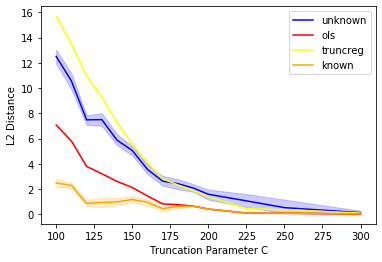

In [65]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='yellow')
ax = sns.lineplot(data=known_logs, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

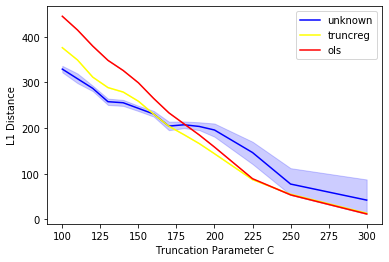

In [64]:
# plot results for regression noise variance MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown', color="blue")
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='yellow')
ax = sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance')
# ax.set(ylim=(0, .05))
plt.show()

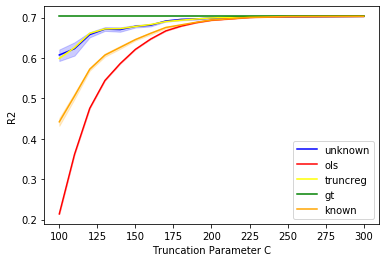

In [23]:
# plot results for regression parameter MSE
sns.lineplot(data=logs, x='c', y='unknown_r2', label='unknown', color='blue')
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red')
sns.lineplot(data=logs, x='c', y='trunc_reg_r2', label='truncreg', color='yellow')
plt.plot(C, [gt_r2]*len(C), label='gt', color='green')
ax = sns.lineplot(data=logs, x='c', y='known_r2', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='R2')
plt.show()

In [30]:
trunc_reg.score()

tensor(0.0427, grad_fn=<CopyBackwards>)

In [559]:
gt_var

tensor([1033.5864])

In [560]:
emp_noise_var

tensor([[84.9927]])

In [561]:
known_params

tensor([5.9732e-03, 4.2906e-02, 5.9897e+01])

In [562]:
gt_params

tensor([ -0.0697,   0.2125, -22.8026])

In [563]:
ols_params

tensor([-2.5557e-03,  3.7274e-02,  9.1479e+00])

In [571]:
unknown_trunc_reg.weight.size()

torch.Size([2, 1])

In [42]:
gt_r2

0.5411531520066606

In [57]:
trunc_reg.variance * emp_noise_var 

tensor([[219.6276]])

In [24]:
unknown_params

tensor([-0.0762,  0.1870, 37.4407])

In [25]:
gt_params

tensor([-0.1166,  0.2347, 58.3021])

In [26]:
ols_params

tensor([-0.0484,  0.1163, 46.0508])

In [27]:
known_params

tensor([-4.7087e-02,  1.1756e-01,  5.3071e+01])